# MovieLens Rating Prediction

$\textbf{Data Source}$: 
MovieLens Dataset https://grouplens.org/datasets/movielens/

$\textbf{Data Preparation}$:
To run this Jupyter Notebook, download the MovieLens 20M dataset version from the above website. Then place the 'ratings.csv' file in the 'MovieLens' directory of your cloned version of the NeuralNetworkLibrary repository.

$\textbf{Objective}$:
Collaborative Filtering - Predict how users will rate movies (on scale of 0.5 to 5).

In [1]:
# Automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Imports
import sys
sys.path.append("../")
from Applications.CollabFiltering import *

### Quick Look at the Data

In [2]:
ratings_df = pd.read_csv('MovieLens/ratings.csv')
print(len(ratings_df))
ratings_df.head(20)

20000263


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580
5,1,112,3.5,1094785740
6,1,151,4.0,1094785734
7,1,223,4.0,1112485573
8,1,253,4.0,1112484940
9,1,260,4.0,1112484826


In [3]:
num_users = len(ratings_df['userId'].unique())
num_movies = len(ratings_df['movieId'].unique())
ratings_value_counts = ratings_df['rating'].value_counts()

print('num users =', num_users)
print('num movies =', num_movies)
print('ratings_value_counts')
print(ratings_value_counts)

num users = 138493
num movies = 26744
ratings_value_counts
4.0    5561926
3.0    4291193
5.0    2898660
3.5    2200156
4.5    1534824
2.0    1430997
2.5     883398
1.0     680732
1.5     279252
0.5     239125
Name: rating, dtype: int64


So, we have 138,493 different users, 26,744 different movies, and users rate movies with values in range [0.5,5]. Of course, most users have not rated most movies. Our goal is to predict how a user will rate a movie they have not yet seen.

### Define DataObj, Model, and Learner

In [4]:
PATH = 'MovieLens/'
data = CollabFilterDataObj.from_csv('MovieLens/ratings.csv','userId','movieId','rating',bs=8192)
model = CollabFilterNet.from_dataobj(data, emb_dim=30, output_range=[0.45,5.05])
learner = Learner(PATH, data, model, optimizer='Adam')

NOTE 1: It is good to set the $\textbf{output_range}$ parameter slighlty larger than the true range of possible outputs (in our case [0.5,5.0]). This is because we use a scaled+shifted sigmoid function to force predictions into the specified range, so the listed max/min are not really acheivable. It would require an input of +/- infinity to the sigmoid.

NOTE 2: The embedding dimension parameter, $\textbf{emb_dim}$, controls how many different 'dimensions' or 'properties' are important to a user in rating an item (as far as the model is concerned). For instance, we might have things like 'comedy content', 'dialogue quality', or 'action content' for movies. However, these properties are not pre-specified when creating the model, but rather the important properties are inferred from the data. All we pick is the number of them we think might be reasonable. 

For movies, which are a relatively complex and varied thing to evaluate, a fairly large embedding dimension of 30 seemed reasonable. For something simpler like rating a pair of sneakers, a lower emedding dimension (perhaps 4 or 5) might be better. Using too small of an embedding dimension leads to a less complex model, which may not capture all the important relations in the rating process, and thus give poorer results. However, choosing too high of an embedding dimension can lead to overfitting. 

### Training

We will use L2 weight decay (wd) to avoid overfitting. Because many movies have been rated by only a few users, there may be some tendency to overfit to training data, even if the embedding dimension is not too high. (I first tried without weight decay, and results were not quite as good, over a range of embedding dimensions.) 

We will also use the one-cycle training procedure, instead of training with a constant learning rate and then cycles. 
This procedure tends to work well for networks that do NOT have a pretrained component (like vision models do).

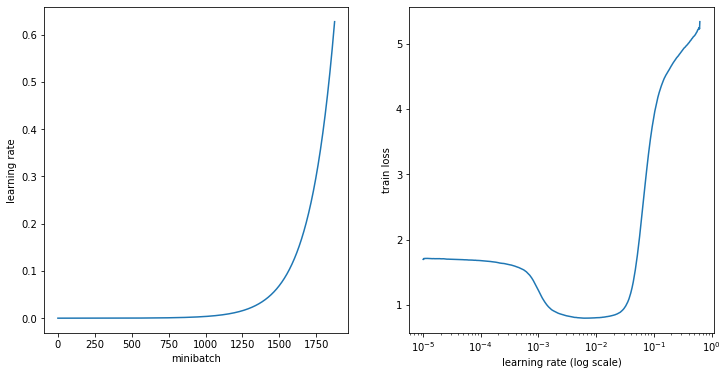

In [5]:
# Select Learning Rate
learner.find_lr(wd=1e-4)

In [6]:
# Train using the one cycle method for 2 epochs 
learner.fit_one_cycle(lr_max=0.01, num_epochs=2,  wd=1e-4, save_name='1cycle', save_method='best')

# NOTE:
# For the one-cycle procedure it is advisable to choose a learning rate somewhat higher than 
# normal. Usually about the minimum of the train_loss curve (from find_lr method) or slightly above the 
# min, rather than a factor of 10 below min.

epoch   train_loss  val_loss    

0       0.65897     0.65799       epoch run time: 1 min, 27.34 sec
1       0.56361     0.61741       epoch run time: 1 min, 26.40 sec


In [7]:
loss = learner.evaluate('val')[0]
print('mean squared error =',loss)
print('root mean squared error =',np.sqrt(loss))

mean squared error = 0.6174121380209083
root mean squared error = 0.7857557750477615


Plots below show what the one-cycle procedure looks like in terms of lr and betas schedules during training. (With an SGD optimizer, momemtum schedule follows same trend as the betas_1 schedule for Adam optimizer.)

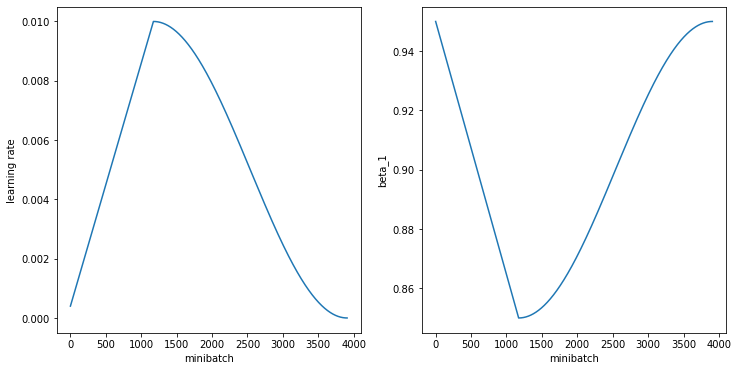

In [8]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
learner.plot_lr_sched()

plt.subplot(1,2,2)
learner.plot_beta_sched()

### Ensembling

This single-model result is decent, but we will now try to improve it by creating an ensemble using different embedding sizes. For simplicity, we will use the same training procedure for all sizes, and not try to tune the learning rate or other training parameters to the embedding sizes. 

In [9]:
PATH = 'MovieLens/'
data = CollabFilterDataObj.from_csv('MovieLens/ratings.csv','userId','movieId','rating',bs=8192)

emb_dims = [10,20,30,50]
Models = [] 
val_losses = {}

for emb_dim in emb_dims:
    
    clear_output()
    print('emb_dim = ',emb_dim)
    model = CollabFilterNet.from_dataobj(data, emb_dim, output_range=[0.45,5.05])
    learner = Learner(PATH, data, model, optimizer='Adam')
    learner.fit_one_cycle(lr_max=0.01, num_epochs=2,  wd=1e-4, save_name='emb'+str(emb_dim), save_method='best')    
    
    learner.load('emb'+str(emb_dim))
    Models.append(learner.model)
    loss = learner.evaluate('val')[0]
    val_losses[emb_dim] = loss 
    
clear_output()

In [10]:
#Losses for each embedding dimension 10,20,30,50
for k,v in val_losses.items():
    print(k,v)

10 0.6320610709132282
20 0.6179949893679914
30 0.61756830313512
50 0.6245555911663925


So, we see the results from an embedding dimension of 30 were best, but the losses are pretty stable 
over the range of embedding dimensions 10 to 50. 

In [11]:
# Create Ensemble
EnsembleModel = CollabFilterEnsembleNet(Models)
learner.model = EnsembleModel

# Evaluate Predictions of Ensemble Model
loss = learner.evaluate('val')[0]
print('mean squared error =',loss)
print('root mean squared error =',np.sqrt(loss))

mean squared error = 0.596770850674031
root mean squared error = 0.7725094502166501
